Figure 2 from DA6 by American Wood Council, 2007

Revision History:
- 1.0 26-Jul-2019 E.Durham added deflection calculation using equivalent point loads
- 0.0 25-Jul-2019 E.Durham created initial notebook from Beam_1.1.ipynb.

TODO:
- Add test data and expected results

Beam Case: Simply Supported Beam - Uniform Load Partially Distributed

When Given the following values:
- span of beam, L in one of the listed length units
- magnitude of load, w in one of the listed force units per unit of length
- distance from left end of beam to start of load, a in one of the listed length units
- length of uniform load, b in one of the listed length units
- distance from left end of beam to point of interest, x in one of the listed length units
- EI of member, use 1 * N * mm**2 if unknown; otherwise
    - E is Young's Modulus in one of the listed pressure units
    - I is Second Moment of Area in one of the listed length units to the 4th power
- number of samples along beam, SAMPLE_SIZE in integer

This notebook will derive the following:
- distance from right end of load to right end of beam, c
- reactions at ends of beams, R_1 and R_2
- plot graphs of shear, moment and deflection
- and list maximum values for each

Acceptable units:
- Length: m, mm, inch, foot
- Force: N, kN, lbf, kip
- Pressure: kPa, MPa, psi, ksi

In [1]:
import numpy as np

# Pint Unit Library
from pint import UnitRegistry
unit = UnitRegistry()
Q_ = unit.Quantity
unit.default_format = '~' # ~ for unit abreviations, P for prettyprint, or both
# Define symbols for common units
# Length
m = unit.meter; mm = unit.millimeter; inch = unit.inch; foot = unit.foot;
# Force
N = unit.newton; kN = unit.kilonewton; lbf = unit.pound_force; kip = unit.kip
# Pressure
kPa = unit.kilopascal; MPa = unit.megapascal; psi = unit.psi; ksi = unit.ksi;
# Mass
kg = unit.kilogram; lbs = unit.pound;
# Acceleration
g_0 = unit.standard_gravity

In [2]:
# ======= ========= ========= ========= ========= ========= ========= =========
# USER: Enter case values using units listed above
# force; Example: w = 1 * N / mm
w = 10 * N / mm
# distance from left end of beam to point of load; Example a = 1000 * mm
a = 1950 * mm
# length of uniform load, b; Example b = 1000 * mm
b = 100 * mm
# span of beam; Example L = 3000 * mm
L = 4000 * mm
EI = 1 * N*mm**2 # default, otherwise enter E and I below
# Young's Modulus for material; Example E = 200000 * MPa
E = 200000 * MPa
# Second Moment of Area for shape; Example I = 0.145*10**6 * mm**4
I = 0.145*10**6 * mm**4 
SAMPLE_SIZE = 99 # number of points within beam to compute, 99 is common
# USER: Enter case values above. Altering anything below can be harmful.
# ======= ========= ========= ========= ========= ========= ========= =========

In [3]:
DEBUG = False
# convert units of user variables to newton for force and millimetres for distance
try :
    w.ito(N/mm)
    a.ito(mm)
    b.ito(mm)
    L.ito(mm)
    SAMPLE_SIZE = int(SAMPLE_SIZE)
    EI = (E*I).to(N*mm**2)
except:
    print('ERROR: The user entered values cannot be converted to expected units. Results below are highly suspect.')
    print('Please, re-enter user values using accepted units and re-run notebook')
# Derive distance c
c = L - (a + b)
# Calculate Reactions
# reaction at left support
R_1 = ((w*b)/(2*L))*(2*c + b) # max when a < c
# reaction at right support
R_2 = ((w*b)/(2*L))*(2*a + b) # max when a < c
# Derive Shear V_1 and V_2
V_1 = R_1
V_2 = R_2
# Derive max moment
M_max_value = str(round((R_1*(a+(R_1/(2*w)))),3))
M_max_location = a + (R_1/w)
# TODO: Derive max deflection
# D_max_value = 
# D_max_value = str(round(D_max_value, 3))
# D_max_location = 
# D_max_location = 

def shear_x(x, w, a, b, L):
    """
    Determine shear for simple beam w/ partial uniformly distributed load at any position x.
    
    where
    x = distance from left end of beam to point of interest
    w = uniform load
    a = distance from left end of beam to start of load
    b = length of uniform load
    L = length of span of beam

    The function does not allign units. Units of x, a, b and L must be identical. 

    Returns value of shear at x in units_of_w * units_of_L
    
    """
    c = L - (a + b) # derive c given a, b and L
    R_1 = ((w*b)/(2*L))*(2*c + b)
    R_2 = ((w*b)/(2*L))*(2*a + b)
    if x >= 0*x.units and x <= a:
        V_x = R_1
    elif x >= (a+b) and x <= L:
        V_x = -R_2
    elif x > a and x < (a+b):
        V_x = R_1 - w*(x-a)
    else:
        V_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return V_x

def moment_x(x, w, a, b, L):
    """
    Determine moment for simple beam w/ concentrated load at any position x.

    where
    x = distance from left end of beam to point of interest
    w = uniform load
    a = distance from left end of beam to point of load
    b = length of uniform load
    L = length of span of beam

    The function does not allign units. Units of x, a, b and L must be identical. 

    Returns value of moment at x in units_of_P * units_of_x
    """
    c = L - (a + b) # derive c given a, b and L
    R_1 = ((w*b)/(2*L))*(2*c + b)
    R_2 = ((w*b)/(2*L))*(2*a + b)
    if x >= 0*x.units and x < a:
        M_x = R_1*x
    elif x >= a and x <= (a+b):
        M_x = R_1*x - ((w/2)*(x-a)**2)
    elif x > (a+b):
        M_x = R_2*(L-x)
    else:
        M_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return M_x

def deflection_x(x, w, a, b, L, EI=1):
    """
    Determine deflection for simple beam w/ partial uniform load at any position x.

    where
    x = distance from left end of beam to point of interest
    w = uniform load
    a = distance from left end of beam to start of load
    b = length of uniform load
    L = length of span of beam
    EI = modulus of elasticity of material in units_of_P / units_of_L**2 times
    second moment of area in units_of_L**4. Thus, EI is in units_of_P * units_of_L**2.
    Default value for EI is 1 in which case values returned are overstated by actual value
    of EI. That is, to determine deflection for a given EI, divide deflection here by
    actual value of EI.

    The function does not allign units. Units of x, a, b and L must be identical. 

    Returns value of deflection at x in units_of_L
    """
    c = L - (a + b) # derive c given a, b and L
    R_1 = ((w*b)/(2*L))*(2*c + b)
    R_2 = ((w*b)/(2*L))*(2*a + b)
    deflection_x = 0 * L.units
    return deflection_x
def deflection_1_x(x, P, a, L, EI=1):
    """
    Determine deflection for simple beam w/ concentrated load at any position x.

    where
    x = distance from left end of beam to point of interest
    P = concentrated load
    a = distance from left end of beam to point of load
    L = length of span of beam
    EI = modulus of elasticity of material in units_of_P / units_of_L**2 times
    second moment of area in units_of_L**4. Thus, EI is in units_of_P * units_of_L**2.
    Default value for EI is 1 in which case values returned are overstated by actual value
    of EI. That is, to determine deflection for a given EI, divide deflection here by
    actual value of EI.

    The function does not allign units. Units of x, a and L must be identical. 

    Returns value of deflection at x in units_of_L
    """
    b = L - a # derive b given a and L
    if x == a:
        deflection_x = -(P*a**2*b**2)/(3*EI*L)
    elif x >= 0*x.units and x < a:
        deflection_x = -((P*b*x)/(6*EI*L))*(L**2-b**2-x**2)
    elif x > a and x <= L:
        deflection_x = -((P*a*(L-x))/(6*EI*L))*(2*L*x-x**2-a**2)
    else:
        deflection_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return deflection_x
# convert partially distributed uniform load into equivalent point loads
P_quantity = int((b/L)*SAMPLE_SIZE)
Normal_Tributary_width = L/SAMPLE_SIZE
P = (w*b)/P_quantity

P_beam_position = np.linspace(0, L.magnitude, SAMPLE_SIZE)
# array of point loads
P_array = np.zeros(SAMPLE_SIZE)
for i in range(SAMPLE_SIZE):
    if i*Normal_Tributary_width < a:
        P_array[i] = 0
    elif i*Normal_Tributary_width >= a and i*Normal_Tributary_width <= (a+b):
        P_array[i] = P.magnitude
    else:
        P_array[i] = 0

# array of deflections
rows = SAMPLE_SIZE
cols = SAMPLE_SIZE
P_beam = np.zeros((rows, cols))


for i in range(rows):
    for j in range(cols):
        local_x = P_beam_position[j]*L.units
        local_P = P_array[i]*(w.units/L.units)
        local_a = (i*Normal_Tributary_width) # ???!!!???
        local_L = L
        local_EI = EI
        P_beam[i, j] = deflection_1_x(local_x, local_P, local_a, local_L, local_EI).magnitude

Agreement_Index = 1/(P_array.sum()/(w*b).magnitude)
if DEBUG == True:
    print('w = {}'.format(w))
    print('L = {}'.format(L))
    print('a = {}'.format(a))
    print('b = {}'.format(b))
    print('c = {}'.format(c))
    print('P_quantity: {}'.format(P_quantity))
    print('Normal_Tributary_width: {}'.format(Normal_Tributary_width))
    print('Agreement_Index (1.0 is ideal): {}'.format(Agreement_Index.magnitude))
    print('P is {}'.format(P))
    print('P_array is')
    print(P_array)
    print('P_beam is')
    print(P_beam)

In [4]:
# create beam array and load with position, shear, moment and deflection values
beam = np.zeros((4, SAMPLE_SIZE))
POSITION = 0 # array row for position along the beam
SHEAR = 1 # array row for shear along the beam
MOMENT = 2
DEFLECTION = 3
beam[POSITION, : ] = np.linspace(0, L.magnitude, SAMPLE_SIZE) # position
for i in range(SAMPLE_SIZE):
    beam[SHEAR, i] = shear_x(beam[POSITION, i]*L.units, w, a, b, L).magnitude # stuff shear values
    beam[MOMENT, i] = moment_x(beam[POSITION, i]*L.units, w, a, b, L).magnitude # stuff moment values
    beam[DEFLECTION, i] = P_beam[  : , i ].sum() # stuff deflection values

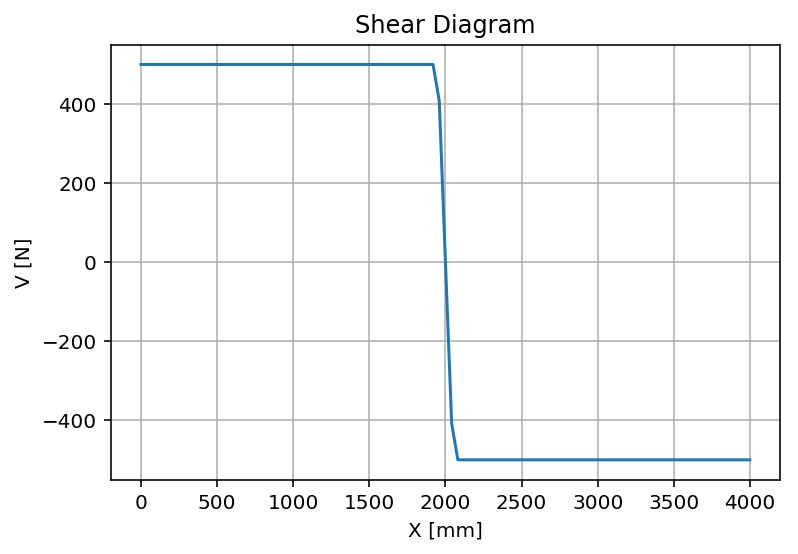

Left Reaction = V_1 = 500.0 N
Right Reaction = -V_2 = 500.0 N


In [5]:
# plot shear diagram with matplotlib
import matplotlib.pyplot as plt
plt.ion()
# %matplotlib inline
ax = plt.plot(beam[POSITION, : ], beam[SHEAR, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel(str('V [' + str(V_1.units) + ']'))
plt.title('Shear Diagram')
# plt.legend()
# cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
plt.show()
print('Left Reaction = V_1 = {}'.format(round(R_1, 3)))
print('Right Reaction = -V_2 = {}'.format(round(R_2, 3)))

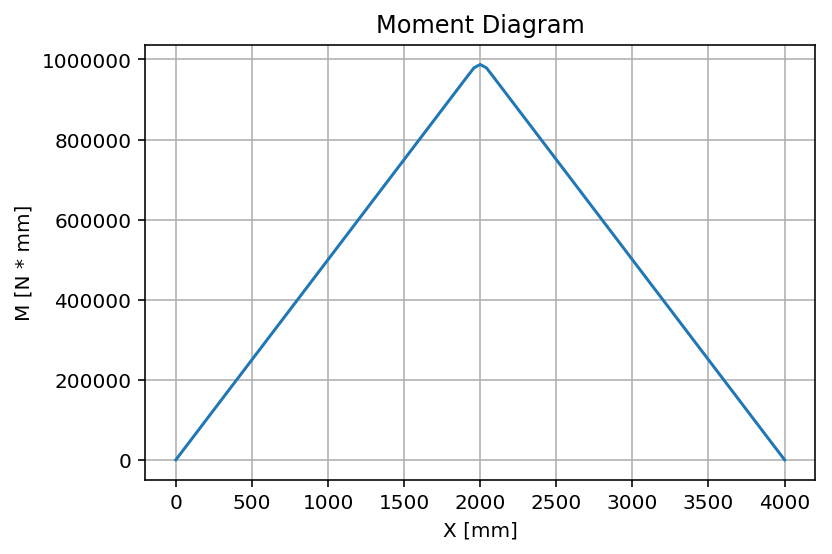

Maximum moment at 2000.0 mm is 987500.0 N * mm


In [6]:
# from matplotlib.widgets import Cursor
bx = plt.plot(beam[POSITION, : ], beam[MOMENT, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel(str('M [' + str(V_1.units * L.units) + ']'))
plt.title('Moment Diagram')
# plt.legend()
# cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
plt.show()
print('Maximum moment at {} is {}'.format(M_max_location, M_max_value))

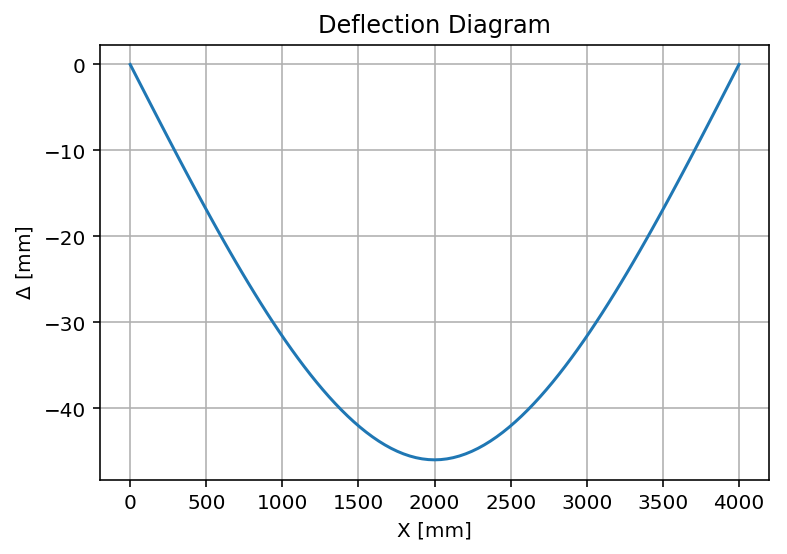

Location of maximum deflection: 2000.0 mm
Value of maximum deflection: -45.97 mm
Agreement_Index:  1.0
(1.0 is ideal, < 0.95 means sample size is too small and deflection values are spurious!)


In [7]:
# plot deflection diagram
cx = plt.plot(beam[POSITION, : ], beam[DEFLECTION, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel('$\Delta$'+ ' [' + str(L.units) + ']')
plt.title('Deflection Diagram')
# plt.legend()
plt.show()
# print('Maximum deflection at {} is {}'.format(D_max_location, D_max_value))
D_index = beam[DEFLECTION, : ].argmin()
D_value = beam[DEFLECTION, D_index]
D_location = beam[POSITION, D_index]

print('Location of maximum deflection: {} mm'.format(round(D_location, 4)))
print('Value of maximum deflection: {} mm'.format(round(D_value, 4)))
print('Agreement_Index:  {}'.format(Agreement_Index))
print('(1.0 is ideal, < 0.95 means sample size is too small and deflection values are spurious!)')

End of Results

Test and ancillary data is below in hidden cells.

To view test data:
- Select cells below
- Then click "Edit" on the menu
- Then click "Toggle Hide Input of Cells"

In [8]:
D_index = beam[DEFLECTION, : ].argmin()
D_value = beam[DEFLECTION, D_index]
D_location = beam[POSITION, D_index]
print(D_index)
print(D_value)
print(D_location)

49
-45.96999860678092
2000.0


In [9]:
F_y = 350*MPa
F_y.ito(kN/m**2)
E.to(kN/m**2)

<Quantity(200000000.0, 'kilonewton / meter ** 2')>

In [10]:
steel_density = 7850 * kg/m**3
steel_density_for_STAAD = steel_density * g_0
steel_density_for_STAAD.ito(kN/m**3)
steel_density_for_STAAD

<Quantity(76.9822025, 'kilonewton / meter ** 3')>

In [11]:
steel_shear_modulus = 77_000*MPa
steel_shear_modulus.to(kN/m**2)

<Quantity(77000000.0, 'kilonewton / meter ** 2')>